In [2]:
!pip3 install xgboost #installing the Xgboost module

In [3]:
#Importing the necessary libararies for the analysis
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

## Loading the data into the pandas dataframe

In [4]:
#reading the data using the pandas module
df=pd.read_csv("eth_15min.csv")
df=df.rename(columns={'Unnamed: 0': 'timestamp'})
df=df.set_index("timestamp") #setting the timestamp as index

## Feature Engineering

In [5]:
def createFeatures(df):
    et = pd.DataFrame(df)

    
    df['Close_Diff'] = df['Close'].diff()
        
    # Moving averages - different periods
    df['MA200'] = df['Close'].rolling(window=200).mean() 
    df['MA100'] = df['Close'].rolling(window=100).mean() 
    df['MA50'] = df['Close'].rolling(window=50).mean() 
    df['MA26'] = df['Close'].rolling(window=26).mean() 
    df['MA20'] = df['Close'].rolling(window=20).mean() 
    df['MA12'] = df['Close'].rolling(window=12).mean() 
    
    # SMA Differences - different periods
    df['DIFF-MA200-MA50'] = df['MA200'] - df['MA50']
    df['DIFF-MA200-MA100'] = df['MA200'] - df['MA100']
    df['DIFF-MA200-CLOSE'] = df['MA200'] - df['Close']
    df['DIFF-MA100-CLOSE'] = df['MA100'] - df['Close']
    df['DIFF-MA50-CLOSE'] = df['MA50'] - df['Close']
    
    # Moving Averages on high, lows, and std - different periods
    df['MA200_low'] = df['Low'].rolling(window=200).min()
    df['MA14_low'] = df['Low'].rolling(window=14).min()
    df['MA200_high'] = df['High'].rolling(window=200).max()
    df['MA14_high'] = df['High'].rolling(window=14).max()
    df['MA20dSTD'] = df['Close'].rolling(window=20).std() 
    
    # Exponential Moving Averages (EMAS) - different periods
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['EMA100'] = df['Close'].ewm(span=100, adjust=False).mean()
    df['EMA200'] = df['Close'].ewm(span=200, adjust=False).mean()

    # Shifts (one day before and two days before)
    df['close_shift-1'] = df.shift(-1)['Close']
    df['close_shift-2'] = df.shift(-2)['Close']

    # Bollinger Bands
    df['Bollinger_Upper'] = df['MA20'] + (df['MA20dSTD'] * 2)
    df['Bollinger_Lower'] = df['MA20'] - (df['MA20dSTD'] * 2)
    
    # Relative Strength Index (RSI)
    df['K-ratio'] = 100*((df['Close'] - df['MA14_low']) / (df['MA14_high'] - df['MA14_low']) )
    df['RSI'] = df['K-ratio'].rolling(window=3).mean() 

    # Moving Average Convergence/Divergence (MACD)
    df['MACD'] = df['EMA12'] - df['EMA26']
    
    df['HL']=df['High']-df['Low']
    df['upper shadow']=df['High']-df[['Close','Open']].max(axis=1)
    df['lower shadow']=df[['Close','Open']].min(axis=1)-df['Low']
    df['volatility indicator']=(df['High']-df['Low'])/df['VWAP']
    df['trend indicator']=(df['Close']-df['Open'])/df['VWAP']
    df['log return']=np.log(df['Close']/df['Open'])
    df['Momentum indicator']=(df['Close']-df['VWAP'])/df['VWAP']
    df['log volume']=np.log(1+df['Volume'])
    df['log count']=np.log(1+df['Count'])
    df['VOL 2 CNT']=df['Volume']/(1+df['Count'])
    
    return df

In [6]:
createFeatures(df)

,Count,Open,High,Low,Close,Volume,VWAP,Final_Target,Close_Diff,MA200,...,HL,upper shadow,lower shadow,volatility indicator,trend indicator,log return,Momentum indicator,log volume,log count,VOL 2 CNT
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-02 00:00:00,0.003662,0.157535,0.157614,0.157065,0.157601,0.002832,0.157564,0.546330,NaN,NaN,...,0.000549,0.000013,0.000470,0.003484,0.000416,0.000416,0.000231,0.002828,0.003655,0.002822
2018-01-02 00:15:00,0.004162,0.158662,0.158642,0.158646,0.158811,0.004279,0.158740,0.550354,0.001210,NaN,...,-0.000004,-0.000169,0.000016,-0.000023,0.000939,0.000939,0.000449,0.004270,0.004153,0.004261
2018-01-02 00:30:00,0.006054,0.159892,0.159816,0.160115,0.160083,0.008870,0.160017,0.635160,0.001272,NaN,...,-0.000300,-0.000267,-0.000224,-0.001872,0.001196,0.001197,0.000411,0.008831,0.006036,0.008817
2018-01-02 00:45:00,0.010403,0.162664,0.162634,0.162281,0.162819,0.013069,0.162755,0.532988,0.002736,NaN,...,0.000353,-0.000185,0.000383,0.002167,0.000950,0.000950,0.000392,0.012984,0.010349,0.012935
2018-01-02 01:00:00,0.009185,0.163607,0.163588,0.163585,0.163808,0.016034,0.163705,0.566638,0.000989,NaN,...,0.000003,-0.000219,0.000022,0.000020,0.001227,0.001227,0.000627,0.015906,0.009143,0.015888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-20 23:15:00,0.106084,0.678958,0.678254,0.679382,0.678950,0.033112,0.679075,0.490194,-0.003664,0.744783,...,-0.001129,-0.000705,-0.000432,-0.001662,-0.000012,-0.000012,-0.000183,0.032575,0.100826,0.029936
2021-09-20 23:30:00,0.098318,0.674762,0.673794,0.675055,0.674654,0.030090,0.674565,0.455695,-0.004296,0.744271,...,-0.001260,-0.000967,-0.000400,-0.001869,-0.000159,-0.000159,0.000132,0.029647,0.093780,0.027397
2021-09-20 23:45:00,0.087173,0.673576,0.672953,0.674331,0.673675,0.028622,0.673872,0.447677,-0.000980,0.743757,...,-0.001379,-0.000722,-0.000755,-0.002046,0.000146,0.000146,-0.000293,0.028220,0.083580,0.026327


In [7]:
#Checking if there are any null values
df.isnull().sum()

Count                     0
Open                      0
High                      0
Low                       0
Close                     0
Volume                    0
VWAP                      0
Final_Target              0
Close_Diff                1
MA200                   199
MA100                    99
MA50                     49
MA26                     25
MA20                     19
MA12                     11
DIFF-MA200-MA50         199
DIFF-MA200-MA100        199
DIFF-MA200-CLOSE        199
DIFF-MA100-CLOSE         99
DIFF-MA50-CLOSE          49
MA200_low               199
MA14_low                 13
MA200_high              199
MA14_high                13
MA20dSTD                 19
EMA12                     0
EMA20                     0
EMA26                     0
EMA100                    0
EMA200                    0
close_shift-1             1
close_shift-2             2
Bollinger_Upper          19
Bollinger_Lower          19
K-ratio                  13
RSI                 

In [8]:
df.dropna(inplace=True) #Dropping all the null values

In [9]:
x=df.drop("Final_Target",axis=1)

In [10]:
y=df['Final_Target']

In [11]:
#Splitting the data into train and test (Train 70%-test 30%)
X_train, X_test= np.split(x, [int(.70 *len(x))])
y_train, y_test= np.split(y, [int(.70 *len(y))])

In [12]:
X_train.corr()

,Count,Open,High,Low,Close,Volume,VWAP,Close_Diff,MA200,MA100,...,HL,upper shadow,lower shadow,volatility indicator,trend indicator,log return,Momentum indicator,log volume,log count,VOL 2 CNT
Count,1.000000,-0.026899,-0.025872,-0.028238,-0.026924,0.930952,-0.026935,-0.049736,-0.019496,-0.022016,...,0.112693,0.098533,0.108068,0.089559,-0.020754,-0.021240,0.010426,0.933738,0.999621,0.929248
Open,-0.026899,1.000000,0.999960,0.999951,1.000000,-0.160049,1.000000,0.000187,0.996145,0.998162,...,0.343129,0.239187,0.381999,0.105112,-0.047381,-0.049392,-0.007071,-0.168701,-0.026545,-0.166906
High,-0.025872,0.999960,1.000000,0.999834,0.999960,-0.158800,0.999959,0.000266,0.996217,0.998194,...,0.351248,0.247875,0.389238,0.109742,-0.046921,-0.048927,-0.006733,-0.167407,-0.025507,-0.165623
Low,-0.028238,0.999951,0.999834,1.000000,0.999952,-0.161345,0.999952,0.000988,0.995956,0.998018,...,0.334123,0.230793,0.372874,0.101789,-0.047426,-0.049437,-0.007184,-0.170039,-0.027894,-0.168228
Close,-0.026924,1.000000,0.999960,0.999952,1.000000,-0.160068,1.000000,0.000694,0.996141,0.998158,...,0.343109,0.239173,0.381959,0.105118,-0.047211,-0.049216,-0.006978,-0.168718,-0.026569,-0.166924
Volume,0.930952,-0.160049,-0.158800,-0.161345,-0.160068,1.000000,-0.160077,-0.036575,-0.155431,-0.156829,...,0.076271,0.090991,0.054990,0.135959,-0.000499,0.000053,0.015219,0.996827,0.928816,0.998536
VWAP,-0.026935,1.000000,0.999959,0.999952,1.000000,-0.160077,1.000000,0.000551,0.996141,0.998158,...,0.343082,0.239150,0.381936,0.105103,-0.047277,-0.049284,-0.007035,-0.168729,-0.026580,-0.166934
Close_Diff,-0.049736,0.000187,0.000266,0.000988,0.000694,-0.036575,0.000551,1.000000,-0.009995,-0.010149,...,-0.036966,-0.025846,-0.057763,-0.006886,0.147177,0.153440,0.056839,-0.034384,-0.049072,-0.034648
MA200,-0.019496,0.996145,0.996217,0.995956,0.996141,-0.155431,0.996141,-0.009995,1.000000,0.999005,...,0.354815,0.250126,0.393202,0.108298,-0.048267,-0.050312,-0.006702,-0.164039,-0.019080,-0.162298
MA100,-0.022016,0.998162,0.998194,0.998018,0.998158,-0.156829,0.998158,-0.010149,0.999005,1.000000,...,0.351166,0.246590,0.389878,0.107045,-0.048419,-0.050474,-0.006797,-0.165478,-0.021634,-0.163711


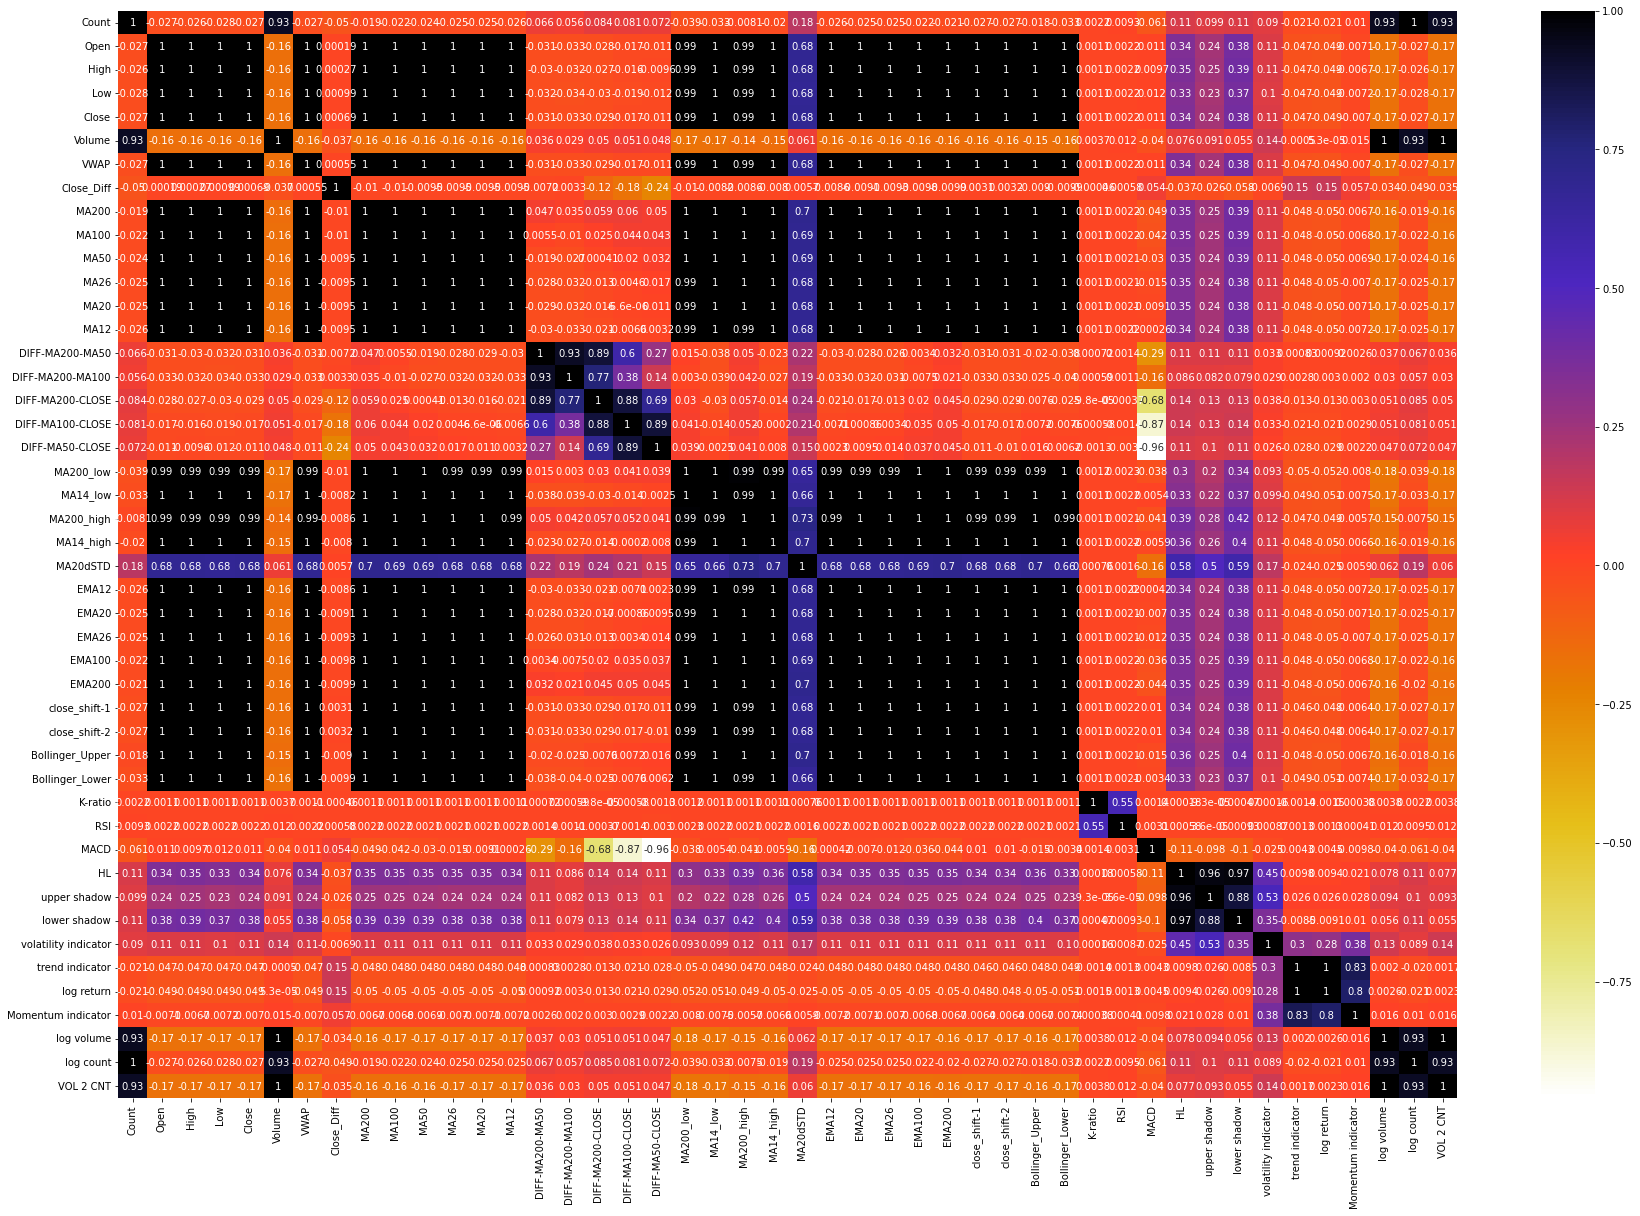

In [13]:
import seaborn as sns
#Using Pearson Correlation
plt.figure(figsize=(30,20))
cor =X_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [14]:
#https://github.com/krishnaik06/Complete-Feature-Selection/blob/master/2-Feature%20Selection-%20Correlation.ipynb

# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [15]:
corr_features = correlation(X_train, 0.7)
len(set(corr_features))

37

In [16]:
corr_features

{'Bollinger_Lower',
 'Bollinger_Upper',
 'Close',
 'DIFF-MA100-CLOSE',
 'DIFF-MA200-CLOSE',
 'DIFF-MA200-MA100',
 'DIFF-MA50-CLOSE',
 'EMA100',
 'EMA12',
 'EMA20',
 'EMA200',
 'EMA26',
 'High',
 'Low',
 'MA100',
 'MA12',
 'MA14_high',
 'MA14_low',
 'MA20',
 'MA200',
 'MA200_high',
 'MA200_low',
 'MA20dSTD',
 'MA26',
 'MA50',
 'MACD',
 'Momentum indicator',
 'VOL 2 CNT',
 'VWAP',
 'Volume',
 'close_shift-1',
 'close_shift-2',
 'log count',
 'log return',
 'log volume',
 'lower shadow',
 'upper shadow'}

In [17]:
X_train=X_train.drop(corr_features,axis=1)
X_test=X_test.drop(corr_features,axis=1)

In [18]:
X_train.shape,X_test.shape

((91117, 9), (39051, 9))

In [19]:
X_train.head()

,Count,Open,Close_Diff,DIFF-MA200-MA50,K-ratio,RSI,HL,volatility indicator,trend indicator
timestamp,,,,,,,,,
2018-01-04 01:45:00,0.007147,0.198942,-0.000018,-0.008882,57.189328,55.841512,0.003308,0.016629,-0.000068
2018-01-04 02:00:00,0.010437,0.198526,-0.000428,-0.009001,51.806957,55.470043,0.002020,0.010176,-0.000132
2018-01-04 02:15:00,0.009803,0.197599,-0.000819,-0.009095,41.499924,50.165403,0.000867,0.004385,0.000412
2018-01-04 02:30:00,0.008762,0.197640,0.000113,-0.009175,42.918379,45.408420,0.000629,0.003182,0.000777
2018-01-04 02:45:00,0.006539,0.198390,0.000670,-0.009265,51.343030,45.253778,-0.000070,-0.000352,0.000368


In [20]:
y_train.head()

timestamp
2018-01-04 01:45:00    0.374331
2018-01-04 02:00:00    0.393547
2018-01-04 02:15:00    0.411096
2018-01-04 02:30:00    0.411778
2018-01-04 02:45:00    0.480429
Name: Final_Target, dtype: float64

In [21]:
!pip3 install xgboost

## Model training

In [22]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [22]:
# Fit a lasso model on the training set
model =XGBRegressor().fit(X_train, y_train)
print (model, "\n")

# Evaluate the model using the test data
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...) 

MSE: 0.0015911463947684626
RMSE: 0.03988917641125801


In [23]:
XGBR_results1 = y_test.to_frame()
XGBR_results1["Predicted Return"] =predictions
XGBR_results1

,Final_Target,Predicted Return
timestamp,,
2020-08-10 05:15:00,0.459364,0.454030
2020-08-10 05:30:00,0.448669,0.458450
2020-08-10 05:45:00,0.451345,0.460564
2020-08-10 06:00:00,0.472402,0.457764
2020-08-10 06:15:00,0.447620,0.459874
...,...,...
2021-09-20 22:45:00,0.412207,0.473942
2021-09-20 23:00:00,0.459406,0.501065
2021-09-20 23:15:00,0.490194,0.523453


<AxesSubplot:xlabel='timestamp'>

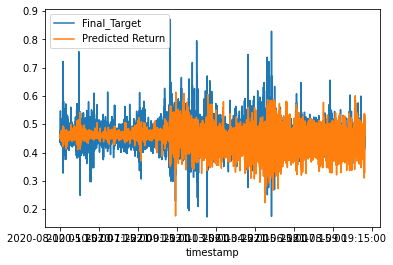

In [24]:
#Visulising the actual vs predicted 
XGBR_results1.plot()

In [23]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error1(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [26]:
#Evaluate the model using just the "Y" training data:

in_sample_results_xgbr1=y_train.to_frame()
print(in_sample_results_xgbr1.shape)

in_sample_results_xgbr1["In-sample Pred"]=model.predict(X_train)

in_sample_mse_xgbr1=mean_squared_error(y_train, in_sample_results_xgbr1["In-sample Pred"])
print("MSE:", in_sample_mse_xgbr1)

rmse = np.sqrt(in_sample_mse_xgbr1)
print("RMSE:", rmse)

print("Test MAPE:",mean_absolute_percentage_error1(y_test, predictions))
print("Train MAPE:",mean_absolute_percentage_error1(y_train,in_sample_results_xgbr1["In-sample Pred"] ))


(91117, 1)
MSE: 0.00031245892226844135
RMSE: 0.01767650763777849
Test MAPE: 6.286504524656864
Train MAPE: 2.6938342241814444


## hyperparameter tuning

In [27]:
#hyperparameter tuning
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
np.random.seed(0)
param_dist = {
            'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}
tuning_model=RandomizedSearchCV(model,param_dist,scoring='neg_mean_absolute_percentage_error',cv=3,verbose=3,error_score='raise',)

tuning_model.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=1000;, score=-95775274860.053 total time=  43.6s
[CV 2/3] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=1000;, score=-0.035 total time=  47.1s
[CV 3/3] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=1000;, score=-0.028 total time=  46.2s
[CV 1/3] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100;, score=-84552475681.607 total time=   4.3s
[CV 2/3] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100;, score=-0.047 total time=   4.2s
[CV 3/3] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100;, score=-0.042 total time=   4.4s
[CV 1/3] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=100;, score=-100763447798.939 total time=   2.5s
[CV 2/3] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_e

RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          callbacks=None, colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=0, gpu_id=-1,
                                          grow_policy='depthwise',
                                          importance_type=None,
                                          interaction_constraints='',
                                          learning_rate=0.300...
                                          max_leaves=0, min_child_weight=1,
                                          missing=nan,
                                          monotone_constrain

In [28]:
tuning_model.best_params_

{'n_estimators': 100,
 'max_depth': 10,
 'learning_rate': 0.01,
 'colsample_bytree': 0.7}

In [29]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error1(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [24]:
xgbr = xgb.XGBRegressor(colsample_bytree=0.7, learning_rate= 0.01, max_depth=10, n_estimators=100)
xgbr.fit(X_train, y_train)
 
y_pred = xgbr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE: " ,(mse))
print("RMSE:", (mse**(1/2.0)))

MSE:  0.001058499853750446
RMSE: 0.03253459472239428


In [25]:
XGBR_results = y_test.to_frame()
XGBR_results["Predicted Return"] =y_pred
XGBR_results

,Final_Target,Predicted Return
timestamp,,
2020-08-10 05:15:00,0.459364,0.471491
2020-08-10 05:30:00,0.448669,0.473056
2020-08-10 05:45:00,0.451345,0.473675
2020-08-10 06:00:00,0.472402,0.472458
2020-08-10 06:15:00,0.447620,0.473192
...,...,...
2021-09-20 22:45:00,0.412207,0.475095
2021-09-20 23:00:00,0.459406,0.565785
2021-09-20 23:15:00,0.490194,0.483755


(array([-5000.,     0.,  5000., 10000., 15000., 20000., 25000., 30000.,
        35000., 40000., 45000.]),
 [Text(-5000.0, 0, '2021-07-30 22:00:00'),
  Text(0.0, 0, '2020-08-10 05:15:00'),
  Text(5000.0, 0, '2020-10-01 07:15:00'),
  Text(10000.0, 0, '2020-11-22 09:15:00'),
  Text(15000.0, 0, '2021-01-13 11:15:00'),
  Text(20000.0, 0, '2021-03-06 13:15:00'),
  Text(25000.0, 0, '2021-04-27 15:15:00'),
  Text(30000.0, 0, '2021-06-18 17:15:00'),
  Text(35000.0, 0, '2021-08-09 19:15:00'),
  Text(40000.0, 0, ''),
  Text(45000.0, 0, '')])

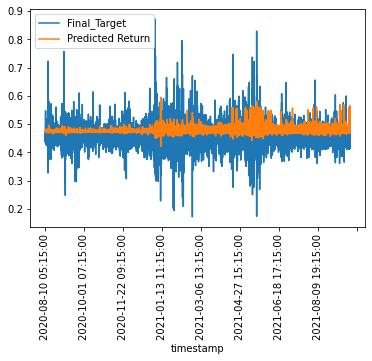

In [27]:
#Visulising the actual vs predicted 
XGBR_results.plot()
plt.xticks(rotation=90)

In [28]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error1(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [29]:
#test MAPE
mean_absolute_percentage_error1(y_test, y_pred)

5.568656434040308

In [30]:
#Evaluate the model using just the "Y" training data:

in_sample_results_xgbr=y_train.to_frame()
print(in_sample_results_xgbr.shape)

in_sample_results_xgbr["In-sample Pred"]=xgbr.predict(X_train)

in_sample_mse_xgbr=mean_squared_error(y_train, in_sample_results_xgbr["In-sample Pred"])
print("MSE:", in_sample_mse_xgbr)

rmse = np.sqrt(in_sample_mse_xgbr)
print("RMSE:", rmse)


(91117, 1)
MSE: 0.0006388596023348948
RMSE: 0.025275672144077492


In [31]:
#Train MAPE
mean_absolute_percentage_error1(y_train, in_sample_results_xgbr["In-sample Pred"])

4.403563553918716